# Weather prediction example

This notebook shows a way to forecast time series data using a PredictLite framework.

(c) Mikko Kursula 2022 - 2024. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data for two different stations
stations = ['02944', '02763']
start_dt = datetime(2020, 1, 1)
end_dt = datetime(2024, 7, 1)
data = []
for station in stations:
    dataset = meteostat.Hourly(station, start_dt, end_dt).fetch()
    dataset['station'] = station
    data.append(dataset)

### Create categorical features

In [3]:
for i, station in enumerate(stations):
    data[i]['station'] = station # We use station as categorical feature
    data[i]['prcp'] = data[i]['prcp'].fillna(0)
    data[i]['prcp_cat'] = (data[i]['prcp'] > 0).astype(str)
    data[i]['wspd_cat'] = (data[i]['wspd'] > 5).astype(str)

### Setup and train PredictLite model 

In [4]:
model = PredictLite(
    input_signals=['temp', 'rhum'], 
    input_preprocessing={'temp' : 'z-norm', 'rhum' : 'z-norm'},
    datetime_embeddings=['month', 'hour'],
    datetime_embedding_dim=6,
    categorical_inputs=['wspd_cat', 'prcp_cat'],
    categorical_embedding_dim=4,
    input_length=72, 
    output_signals=['temp', 'rhum'],
    output_length=24,
    data_sample_period=3600,
    sequential_layer_neurons=[20],
    longitudinal_layer_neurons=[20],
    flattened_layer_neurons=[30, 30],
    percentiles=[0.25, 0.75],
    smoothing_weight=0.1
)

In [6]:
model.fit(
    data=data,
    train_sample_n=10000,
    test_sample_n=1000,
    epochs=20,
    learning_rate=0.0003,
    random_seed=13,
    verbose=True,
)

Setting up preprocessing
Building dataset
Training the model
epoch:   0, train loss: 1.00250, test loss: 0.70653
epoch:   1, train loss: 0.64879, test loss: 0.55468
epoch:   2, train loss: 0.54026, test loss: 0.48830
epoch:   3, train loss: 0.48789, test loss: 0.44063
epoch:   4, train loss: 0.44917, test loss: 0.41714
epoch:   5, train loss: 0.42637, test loss: 0.40520
epoch:   6, train loss: 0.41770, test loss: 0.39827
epoch:   7, train loss: 0.41541, test loss: 0.40049
epoch:   8, train loss: 0.41025, test loss: 0.39856
epoch:   9, train loss: 0.40901, test loss: 0.39928
epoch:  10, train loss: 0.40719, test loss: 0.39249
epoch:  11, train loss: 0.40391, test loss: 0.39306
epoch:  12, train loss: 0.40243, test loss: 0.39046
epoch:  13, train loss: 0.40087, test loss: 0.39001
epoch:  14, train loss: 0.39932, test loss: 0.38838
epoch:  15, train loss: 0.39785, test loss: 0.38727
epoch:  16, train loss: 0.39688, test loss: 0.38817
epoch:  17, train loss: 0.39560, test loss: 0.38680
epo

In [7]:
model.model_summary()

Inputs:
	Float inputs: ['temp', 'rhum']
	Time steps: 72
	month_emb: num_embeddings: 13, embedding_dim: 6
	hour_emb: num_embeddings: 25, embedding_dim: 6
	wspd_cat: num_embeddings: 3, embedding_dim: 4
	prcp_cat: num_embeddings: 3, embedding_dim: 4
MLP sequential part:
	Linear(in_features=22, out_features=20, bias=True), parameter count: 460
	ReLU()
	Flatten(start_dim=-2, end_dim=-1)
MLP longitudinal part:
	Linear(in_features=72, out_features=20, bias=True), parameter count: 1460
	ReLU()
	Flatten(start_dim=-2, end_dim=-1)
MLP flattened part:
	Linear(in_features=1880, out_features=30, bias=True), parameter count: 56430
	ReLU()
	Linear(in_features=30, out_features=30, bias=True), parameter count: 930
	ReLU()
	Linear(in_features=30, out_features=144, bias=True), parameter count: 4464

Total MLP parameter count: 63744


### Make prediction

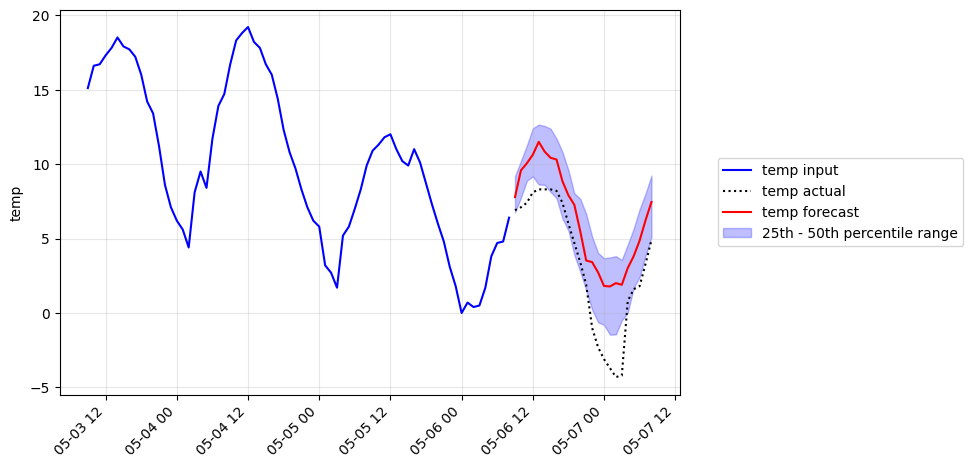

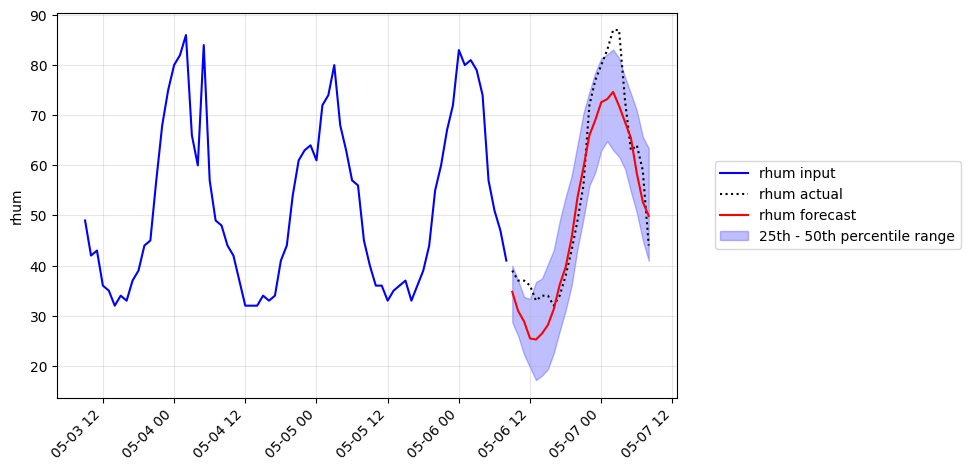

In [8]:
# Give datetime for prediction
prediction_time = datetime(2024, 5, 6, 8)

# Pick the dataset
df = data[0]

# Make prediction 
predictions = model.predict(df, prediction_time)

# Plot everything
for col in model.output_signals:
    ts_idx = dataset.index.get_indexer([prediction_time], method='pad')[0] + 1
    plt.figure(figsize=(8, 5))
    plt.plot(
        dataset.index[ts_idx - model.input_length : ts_idx].values, 
        dataset.iloc[ts_idx - model.input_length : ts_idx][col].values, 
        color='blue', 
        label='{} input'.format(col)
    )
    plt.plot(
        dataset.index[ts_idx : ts_idx + model.output_length].values, 
        dataset.iloc[ts_idx : ts_idx + model.output_length][col].values, 
        color='black',
        ls=':',
        label='{} actual'.format(col)
    )
    plt.plot(
        predictions['prediction'].index.values, 
        predictions['prediction'][col].values, 
        color='red', 
        label='{} forecast'.format(col)
    )
    plt.fill_between(
        predictions['lower_percentile'].index.values, 
        y1=predictions['lower_percentile'][col].values, 
        y2=predictions['upper_percentile'][col].values,
        color='blue', 
        alpha=0.25,
        label='25th - 50th percentile range'
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(col)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.grid(alpha=0.3)
    plt.show()